<center>
<img src="FIFA-19-Background-1-768x401.jpg" />
    
## Aprendizaje No Supervisado 2020 DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

Para visualización usamos plotly, pero podemos usar seaborn tambien, o matplotlib. 

In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [13]:
df=pd.read_csv("datasets/players_20.csv")

In [14]:
print( df.keys() )

Index(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob',
       'height_cm', 'weight_kg', 'nationality', 'club',
       ...
       'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object', length=104)


In [15]:
#positions = positions[positions != 0]
positions = []

#Defensores/Back B
back = [ 'SW','RWB', 'LWB', 'RB', 'LB', 'CB', 'LCB', 'RCB', 'SUB' ]

#Mediocampistas/Midfielders M
midfield=[ 'DM', 'RW', 'LW', 'LM', 'RM', 'CM', 'AM', 'CAM','RCM', 'CDM', 'LDM', 'RM', 'LCM', 'RDM', 'RAM', 'LAM' ]

#Delanteros/Forwards F
forward = ['CF', 'RF', 'LF', 'ST', 'RS', 'LS']

for i in range(len(df['team_position'])):
    if df['team_position'][i] in back:
        positions.append('BK')
    elif df['team_position'][i] in midfield:
        positions.append('MF')
    elif df['team_position'][i] in forward:
        positions.append('FW')
    elif df['team_position'][i] == 'GK':
        positions.append('GK')
    else:
        positions.append(0)

df['simple_position'] = positions
df['simple_position']

0        MF
1        MF
2        MF
3        GK
4        MF
         ..
18273     0
18274    BK
18275    BK
18276    BK
18277    BK
Name: simple_position, Length: 18278, dtype: object

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [59]:
n=100000

df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['overall']>70)] # mejores jugadores

skills_ratings=['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
                'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning',
                'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve',
                'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                'movement_reactions', 'movement_balance', 'power_shot_power',
                'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
                'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking',
                'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 
                'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(len(skills_ratings))

df_n = df_n.fillna(value=0)

df_skills=df_n[skills_ratings]

46


In [60]:
df[['short_name', 'simple_position'] + skills_ratings ]

,short_name,simple_position,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,MF,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,MF,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,MF,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,GK,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,MF,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,Shao Shuai,0,57.0,23.0,28.0,33.0,47.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,21,17,40,35,27,24,23,21,28,35,56,58,45,40,73,36,70,60,47,16,46,48,28,25,39,41,45,50,52,5,5,13,5,14
18274,Xiao Mingjie,BK,58.0,24.0,33.0,35.0,48.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,24,20,42,43,28,32,24,29,39,31,55,61,43,41,76,33,72,55,44,20,42,49,23,25,37,35,42,53,57,13,6,14,11,9
18275,Zhang Wei,BK,54.0,35.0,44.0,45.0,48.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,32,33,49,53,32,40,32,32,55,49,55,54,52,52,57,48,60,50,51,26,50,45,38,38,36,39,46,52,46,7,8,10,6,14
18276,Wang Haijian,BK,59.0,35.0,47.0,47.0,45.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,39,34,47,54,28,42,37,39,48,49,55,63,55,54,59,46,61,42,55,28,57,49,31,48,36,40,39,44,54,14,9,13,13,13


# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [61]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [62]:
std    = preprocessing.StandardScaler().fit(df_skills)
X_s    = std.transform(df_skills) # numpyarray normalizado por columna

In [63]:
minmax = MinMaxScaler().fit(df_skills)
X_mm   = minmax.transform(df_skills)

In [64]:
for i in range(10):
    print( X_mm[i].mean().round(2), X_mm[i].std().round(2), X_s[i].mean().round(2), X_s[i].std().round(2) )

0.64 0.39 0.81 1.22
0.63 0.39 0.8 1.17
0.6 0.38 0.65 1.21
0.42 0.37 -0.29 2.51
0.6 0.38 0.64 1.13
0.64 0.35 0.8 0.94
0.43 0.36 -0.25 2.49
0.59 0.33 0.52 0.87
0.64 0.35 0.75 0.92
0.62 0.35 0.71 0.94


In [65]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(X_mm)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  2049.123528266597


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

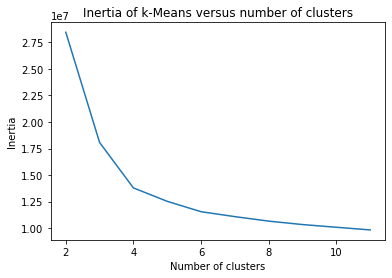

In [66]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(10)]

from matplotlib import pyplot as plt
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

**Graficamos el resultado kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [67]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[34]
skill_2=skills_ratings[38]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [68]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


In [69]:
# Cantidad de observaciones por Cluster

y = km.predict(X_mm)
classes = set(y)
cant_classes = [0, 0, 0, 0]

for element in y:
    if element in classes:
        cant_classes[element] += 1

In [70]:
Observacriones = {
    'Clúster':     [ i for i in range(len(cant_classes)) ],
    'Obsevaciones': [cant_classes[i] for i in range(len(cant_classes)) ]
}
Observacriones = pd.DataFrame(Observacriones)
Observacriones

,Clúster,Obsevaciones
0,0,1728
1,1,440
2,2,1664
3,3,924


In [71]:
# Creo nuevo df y le agrego la columna cluster
df_skills_cluster = df_skills.copy()
df_skills_cluster['cluster'] = y
df_n['cluster'] = y

In [73]:
# Media de cada variable agrupada por cluster
df_skills_cluster.groupby(['cluster']).mean().round(0)

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.0,62.0,71.0,73.0,69.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,57.0,62.0,75.0,56.0,72.0,66.0,59.0,71.0,75.0,70.0,70.0,72.0,73.0,71.0,71.0,69.0,78.0,69.0,65.0,73.0,71.0,66.0,69.0,59.0,72.0,69.0,72.0,69.0,11.0,11.0,11.0,11.0,11.0
1,0.0,0.0,0.0,0.0,0.0,0.0,76.0,73.0,70.0,77.0,44.0,74.0,15.0,13.0,15.0,30.0,14.0,15.0,16.0,15.0,29.0,23.0,44.0,44.0,46.0,71.0,45.0,53.0,65.0,34.0,66.0,14.0,29.0,20.0,13.0,46.0,22.0,54.0,17.0,15.0,14.0,76.0,73.0,70.0,74.0,77.0
2,76.0,71.0,67.0,75.0,37.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,72.0,61.0,71.0,67.0,75.0,67.0,60.0,61.0,75.0,76.0,76.0,76.0,72.0,72.0,74.0,67.0,70.0,66.0,69.0,58.0,35.0,74.0,69.0,67.0,71.0,37.0,34.0,30.0,11.0,11.0,11.0,11.0,11.0
3,59.0,41.0,56.0,57.0,74.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,35.0,73.0,66.0,35.0,53.0,41.0,37.0,62.0,63.0,58.0,60.0,55.0,70.0,54.0,57.0,73.0,68.0,79.0,40.0,76.0,74.0,41.0,49.0,44.0,68.0,74.0,75.0,73.0,11.0,11.0,11.0,11.0,11.0


In [74]:
# Desvío estándar de cada variable agrupada por cluster
df_skills_cluster.groupby(['cluster']).std().round(0)

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10.0,8.0,5.0,5.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,11.0,10.0,5.0,12.0,6.0,10.0,13.0,7.0,5.0,10.0,11.0,8.0,5.0,10.0,8.0,11.0,9.0,9.0,10.0,9.0,7.0,8.0,8.0,11.0,6.0,8.0,7.0,8.0,4.0,4.0,3.0,4.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,6.0,5.0,9.0,5.0,4.0,3.0,4.0,9.0,3.0,4.0,5.0,5.0,10.0,6.0,9.0,9.0,12.0,5.0,10.0,5.0,10.0,7.0,10.0,3.0,8.0,5.0,4.0,13.0,7.0,11.0,5.0,3.0,3.0,5.0,5.0,6.0,5.0,5.0
2,10.0,5.0,8.0,5.0,8.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,6.0,14.0,6.0,9.0,6.0,11.0,14.0,11.0,5.0,11.0,10.0,10.0,6.0,12.0,6.0,13.0,9.0,13.0,7.0,14.0,11.0,6.0,8.0,9.0,7.0,12.0,11.0,10.0,3.0,3.0,3.0,3.0,3.0
3,12.0,8.0,7.0,8.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,10.0,7.0,7.0,10.0,10.0,12.0,12.0,8.0,7.0,12.0,13.0,11.0,5.0,12.0,12.0,11.0,10.0,7.0,13.0,7.0,5.0,12.0,11.0,11.0,7.0,5.0,4.0,5.0,3.0,3.0,4.0,4.0,3.0


### Análisis _silhouette_ y método del codo

Para n_clusters = 2 El silhouette_score promedio es : 0.6890030651400305
Para n_clusters = 3 El silhouette_score promedio es : 0.3600828990111666
Para n_clusters = 4 El silhouette_score promedio es : 0.32761398654458035
Para n_clusters = 5 El silhouette_score promedio es : 0.2877745401664778
Para n_clusters = 6 El silhouette_score promedio es : 0.23485452985726762
Para n_clusters = 7 El silhouette_score promedio es : 0.22681989229469648
Para n_clusters = 8 El silhouette_score promedio es : 0.20083924673000011


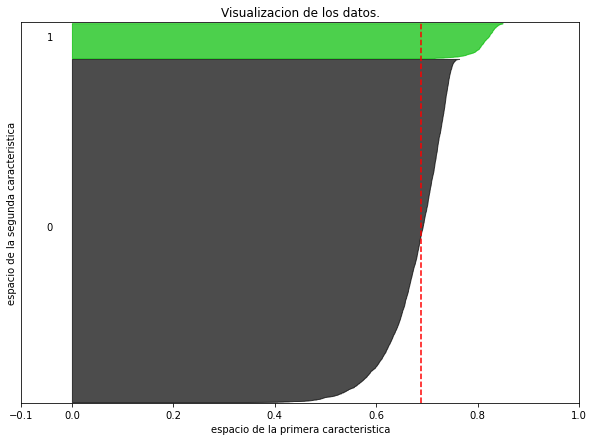

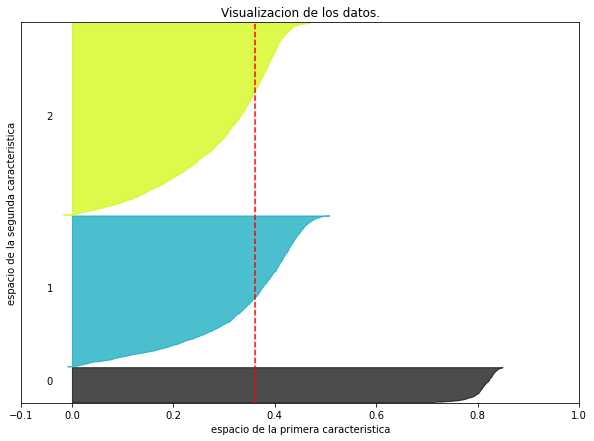

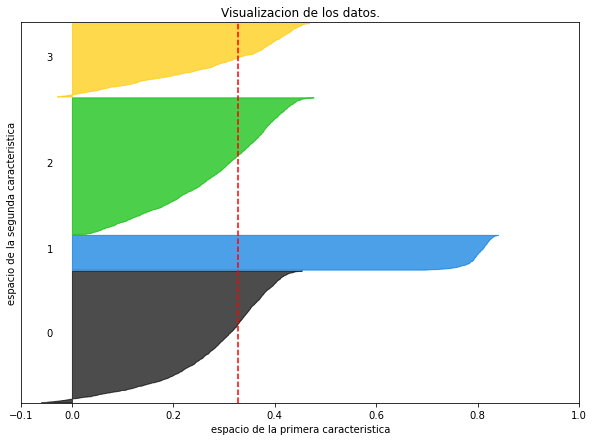

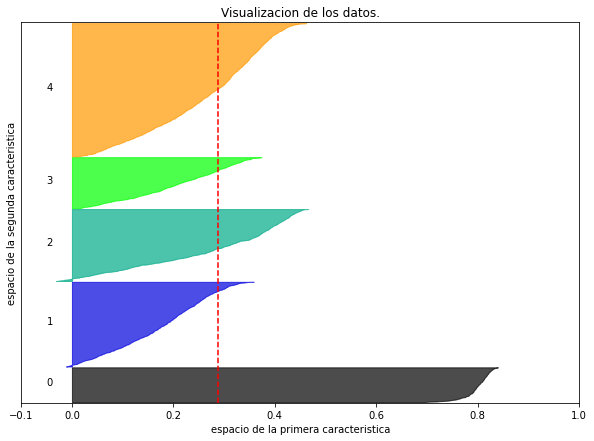

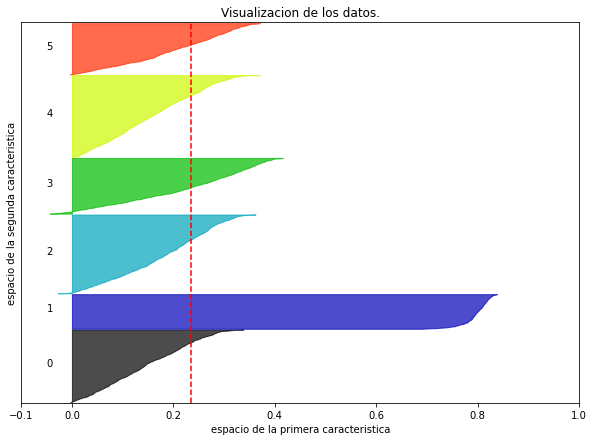

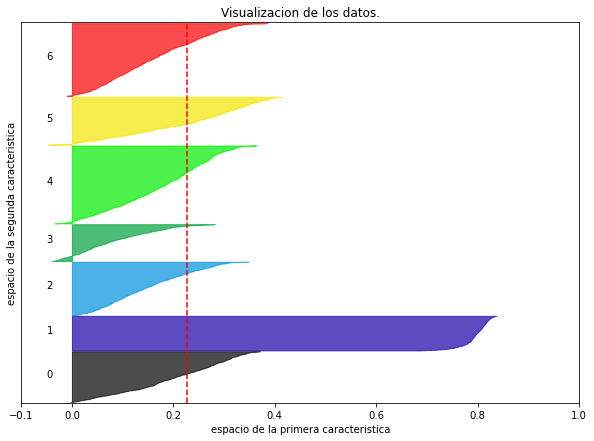

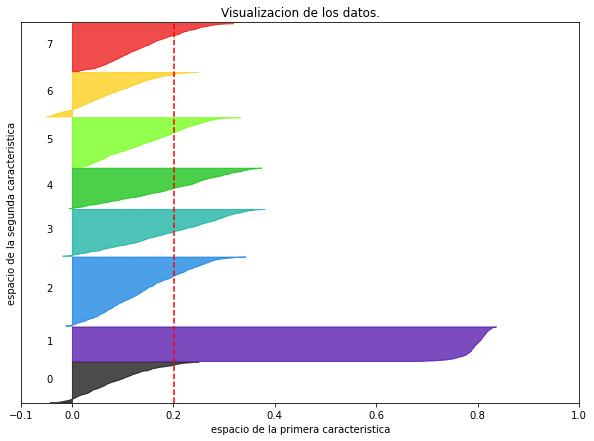

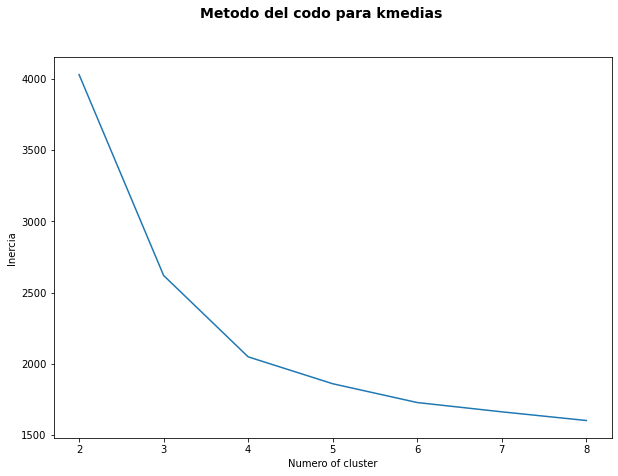

In [104]:
range_n_clusters = [ 2, 3, 4, 5, 6,  7, 8]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_mm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_mm)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_mm, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_mm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
plt.suptitle(("Metodo del codo para kmedias "),
                 fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")

plt.show()

La división en dos clústers muestra un división muy satisfactoria en terminos del coeficiente _silhouette_, ambos grupos están distanciados en el espacio de características que evaluamos. La desventaja de esta clusterización es que es muy desbalaceada. Tenemos un grupo un cluster con coeficiente _silhouette_ promedio mayor a 0.8, que es varias veces menor en términos de cantidad de elementos que el otro.

El desbalance de los clusters es un indicio de que el clúster mayor puede tener una estructura de clústers internos. Efectivamente, al considerar más clusters, siempre aparece uno de similares características al menor de los 2 iniciales, con un perfil _silhouette_ idéntico independientemente de la cantidad de culsters usados, entre 2 y 8.

A medida que incrementamos el número de clústers, los perfiles _silhouette_ se vuelven más desbalanceados internamente. Los clústers en los que se divide el mayor, están cerca por lo que al subdividirlo más y más aparecen en cada cluśter más  elementos con coeficientes _silhouette_ bajo, e incluso negativo.

Utilizando el criterio del codo seleccionamos 4 clústers para subdividir la muestra ya que en el gráfico de inercia versus clústers tiene el mayor cambio de pendiente en este caso.

### Comparación con Variables categóricas

In [121]:
tabla_contingencia = []
for i in range(n_clust):
    C = df_n[df_n['cluster']==i]['simple_position']
    b = 0
    m = 0
    f = 0
    g = 0
    n = 0
    for q in C:
        if q == 'BK':
            b += 1
        elif q == 'MF':
            m += 1
        elif q == 'FW':
            f += 1
        elif q == 'GK':
            g += 1
        else:
            n += 1
    tabla_contingencia.append({
        'cluster' : i,
        'BK': b,
        'MF': m,
        'FW': f,
        'GK': g,
        '0' : n
    })



tabla_contingencia = pd.DataFrame(tabla_contingencia)

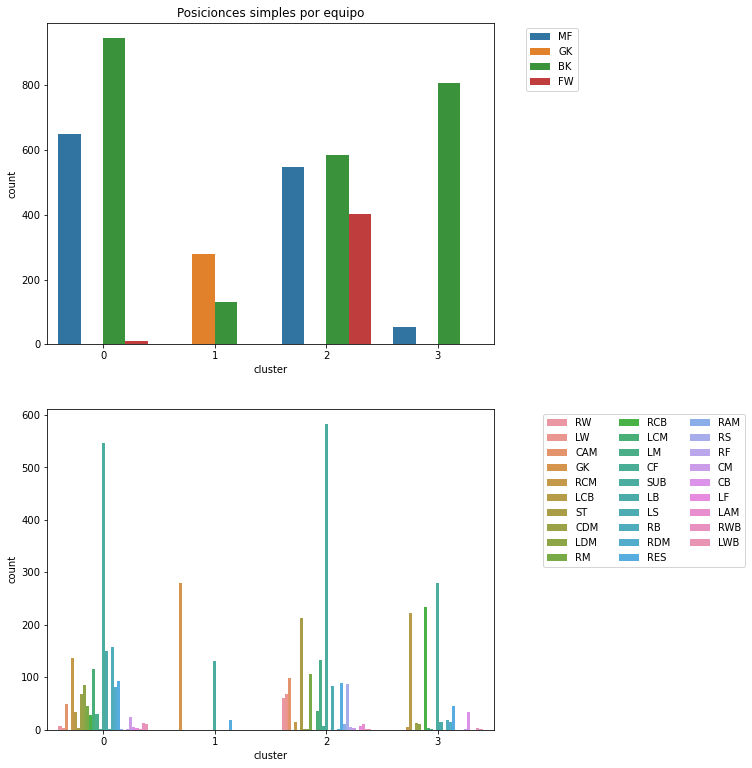

In [103]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(8, 13)

ax1.set_title('Posicionces simples por equipo')
sns.countplot(x='cluster', hue='simple_position', data=df_n[df_n['simple_position']!=0], ax=ax1)
ax1.legend(bbox_to_anchor=(1.2, 1) )

ax3.set_title('Posicionces por equipo')
sns.countplot(x='cluster', hue='team_position', data=df_n[df_n['team_position']!=0], ax=ax2)
ax2.legend(bbox_to_anchor=(1.1, 1), ncol=3 )

#ax3.set_title('Posicionces por selección nacional')
#sns.countplot(x='cluster', hue='nation_position', data=df_n, ax=ax3)
#ax3.legend(bbox_to_anchor=(1.1, 1), ncol=3 )
plt.show()

In [122]:
tabla_contingencia

,cluster,BK,MF,FW,GK,0
0,0,945,649,11,0,123
1,1,131,0,0,279,30
2,2,586,548,404,0,126
3,3,807,53,0,0,64


En el _dataset_ hay tres variables asociadas a las posiciones, *player_positions* que contiene una o varias posiciones asociadas al jugador, *team_position* que tiene una posición en la que juega el jugador en su equipo y *nation_position* que tiene una posición referida a la selección nacional del jugador. Además creamos otra varible categórica *simple_position* que contiene posiciones de los jugadores en sus club, pero reducidas las cuatro grandes categorías análizadas en el fútbol en lugar de las más de 40 subcategorías de estas que contempla el juego FIFA20.

La variable *player_positions* nos resulta compleja para el análisis por que a muchos jugadores los asocia a varias categorías, por que tendríamos que, o bien descartarlos o decidir algún tratamiento de esta variable para poder analizarla. Otro inconveniente sucede con la variable *nation_position* y son mayoría valores los _nan_ o 0 que no corresponden a ninguna categoría, asociados a que ese jugador no juega en ninguan seleción nacional (en el juego).

Nos quedamos con la variable categórica *simple_position*. En el cluster _1_ se encuentran todos los  arqueros y algunos defensores. En el cluster _2_, en cambio están la mayoría de los delanteros, aunque hay más defensores y mediocampistas. En el clúster _0_ hay defensores y mediocampistas y una ínfima parte de los delanteros. Y finalmente en clúster _3_ la mayoría son defensores, y en menor medida mediocampistas.

Podemos decir que por la extructura de los datos, donde los arqueros tienen variables exclusivas, en las que el resto de jugadores tiene valores nulos con exepción de algunos defensores; K-Mean logra separar a los arqueros y a los defensores con habilidades de arquero del resto de jugadores. El resto de los clústers al parecer no están tan relacionados con las categorías de posición.

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio (de cobertura para cálculo de media)

In [123]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

In [124]:
ms = MeanShift(n_jobs=3)
#ms = MeanShift(bandwidth=70, n_jobs=3) # encuentra 6

ms.fit(X_mm)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_)

# Etquetas de los elementos de los clusters

Numero estimado de clusters para Mean Shift : 2


In [125]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[34]
skill_2=skills_ratings[38]

MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [126]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros por defecto')

Kmeans encontró:  4 clusters, nosotros lo forzamos
Mean shift encontró  2 clusters, según los hiperparámetros por defecto


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?

In [127]:
# Cantidad de observaciones por Cluster

y = ms.predict(df_skills)
classes = set(y)
cant_classes = [ 0, 0 ]

for element in y:
    if element in classes:
        cant_classes[element] += 1

In [128]:
Observacriones_ms = {
    'Clúster':     [ i for i in range(len(cant_classes)) ],
    'Obsevaciones': [cant_classes[i] for i in range(len(cant_classes)) ]
}
Observacriones_ms = pd.DataFrame(Observacriones_ms)
Observacriones_ms

,Clúster,Obsevaciones
0,0,4316
1,1,440


In [129]:
# Creo nuevo df y le agrego la columna cluster
df_skills_cluster_ms = df_skills.copy()
df_skills_cluster_ms['cluster'] = y
df_n['cluster_ms'] = y

In [130]:
# Visualizo nuevo dataset
df_skills_cluster_ms.head()

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,cluster
0,87.0,92.0,92.0,96.0,39.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,0
1,90.0,93.0,82.0,89.0,35.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,0
2,91.0,85.0,87.0,95.0,32.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,0
3,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,1
4,91.0,83.0,86.0,94.0,35.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,0


In [131]:
# Media de cada variable agrupada por cluster
df_skills_cluster_ms.groupby(['cluster']).mean().round(0)

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.0,61.0,66.0,70.0,58.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,58.0,64.0,71.0,56.0,69.0,61.0,55.0,65.0,72.0,70.0,70.0,70.0,72.0,68.0,69.0,69.0,73.0,70.0,61.0,68.0,58.0,64.0,65.0,59.0,71.0,58.0,58.0,55.0,11.0,11.0,11.0,11.0,11.0
1,0.0,0.0,0.0,0.0,0.0,0.0,76.0,73.0,70.0,77.0,44.0,74.0,15.0,13.0,15.0,30.0,14.0,15.0,16.0,15.0,29.0,23.0,44.0,44.0,46.0,71.0,45.0,53.0,65.0,34.0,66.0,14.0,29.0,20.0,13.0,46.0,22.0,54.0,17.0,15.0,14.0,76.0,73.0,70.0,74.0,77.0


In [132]:
# Desvío estándar de cada variable agrupada por cluster
df_skills_cluster_ms.groupby(['cluster']).std().round(0)

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,12.0,13.0,9.0,9.0,18.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,17.0,12.0,7.0,16.0,11.0,15.0,16.0,10.0,7.0,13.0,12.0,13.0,6.0,13.0,11.0,12.0,10.0,12.0,15.0,13.0,20.0,15.0,12.0,13.0,7.0,19.0,21.0,21.0,3.0,3.0,3.0,3.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,6.0,5.0,9.0,5.0,4.0,3.0,4.0,9.0,3.0,4.0,5.0,5.0,10.0,6.0,9.0,9.0,12.0,5.0,10.0,5.0,10.0,7.0,10.0,3.0,8.0,5.0,4.0,13.0,7.0,11.0,5.0,3.0,3.0,5.0,5.0,6.0,5.0,5.0


In [133]:
# Parámetros del modelo
ms.get_params()

{'bandwidth': None,
 'bin_seeding': False,
 'cluster_all': True,
 'max_iter': 300,
 'min_bin_freq': 1,
 'n_jobs': 3,
 'seeds': None}

Automatically created module for IPython interactive environment
Para n_clusters = 2 El silhouette_score promedio es : 0.7061332974515504


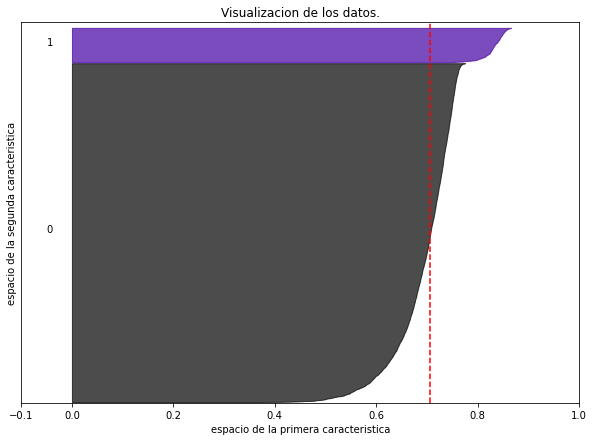

In [90]:
print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = df_skills

# Create a subplot with 1 row and 2 columns
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.

ms.fit(df_skills)

cluster_labels = ms.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("Para n_clusters =", n_clusters_,
      "El silhouette_score promedio es :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters_):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Visualizacion de los datos.")
ax1.set_xlabel("espacio de la primera caracteristica")
ax1.set_ylabel("espacio de la segunda caracteristica")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [91]:
silhouette = []

for i in range(50,160,20):
    ms_ = MeanShift(bandwidth=i, n_jobs=3) # encuentra 6

    cluster_labels_ = ms_.fit_predict(df_skills)

    clusters__ = ms.labels_

    labels_unique_ = np.unique(clusters2)
    n_clusters__ = len(labels_unique_)

    print("Numero estimado de clusters con bandwidth %f : %d" % (i, n_clusters__) )
    print("Silhouette  %f" %( silhouette_score(df_skills, cluster_labels_) ) )
    silhouette.append({
        'bandwidth'  : i,
        'N clusters' : n_clusters__,
        'silhouette' :silhouette_score(df_skills, cluster_labels_)
    })

Numero estimado de clusters con bandwidth 50.000000 : 2
Silhouette  0.001275
Numero estimado de clusters con bandwidth 70.000000 : 2
Silhouette  0.246286
Numero estimado de clusters con bandwidth 90.000000 : 2
Silhouette  0.310358
Numero estimado de clusters con bandwidth 110.000000 : 2
Silhouette  0.706133
Numero estimado de clusters con bandwidth 130.000000 : 2
Silhouette  0.706133
Numero estimado de clusters con bandwidth 150.000000 : 2
Silhouette  0.706133


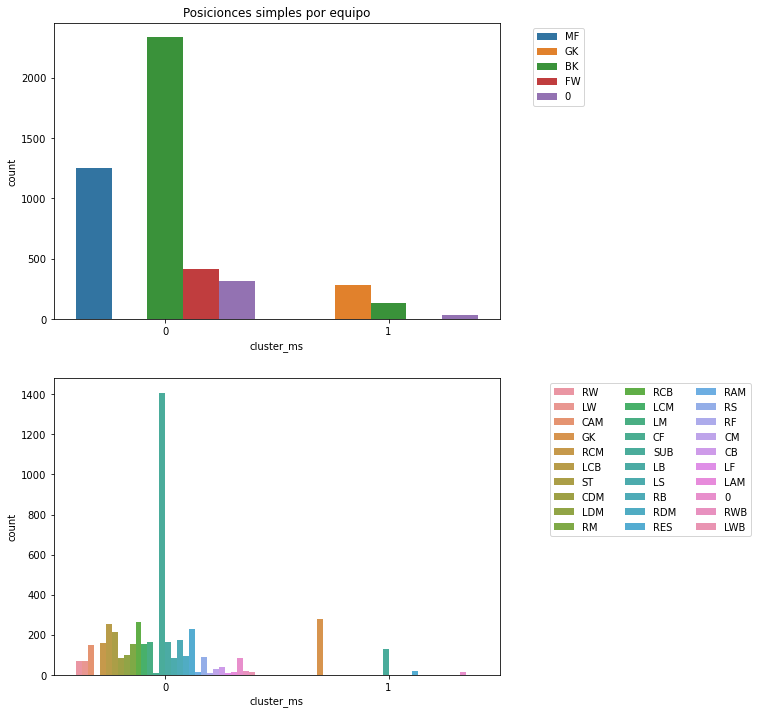

In [135]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

#df_n
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(8, 12)

ax1.set_title('Posicionces simples por equipo')
sns.countplot(x='cluster_ms', hue='simple_position', data=df_n, ax=ax1)
ax1.legend(bbox_to_anchor=(1.2, 1) )

ax3.set_title('Posicionces por equipo')
sns.countplot(x='cluster_ms', hue='team_position', data=df_n, ax=ax2)
ax2.legend(bbox_to_anchor=(1.1, 1), ncol=3 )

**Pregunta: normalizamos/estandarizamos la base?**

Estos algoritmos usan la distancia en el espacio de todas las variables que seleccionadas. Es necesario normalizarlas para que las variables que tienen rangos distintos, no tengan distinta relevancia a la hora de calcular la distancia euclídea (multidimensional). Por ello es óptimo la normalización que garantiza que todas las varialbes tengan dominio [0,1].
Una alternativa es la estandarización que lleva las variables al dominio con media 0 y varianza 1, para cada variable. En general, esto puede no ser óptimo, pero en nuestro casa particular en que todas las varialbes por definición tienen dominio [0,100], esto puede no representar un problema y garantizar que todas las variables tengan varianza 1, puede ser una ventaja para equilibrar el peso de las variables.

# 5.-Clustering-con-Kmeans-sin-arqueros

In [136]:
n=100000

df_n=df.loc[:n]
df_n=df_n[(df_n["player_positions"]!='GK')&(df_n['overall']>69)]

skills_ratings=['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
                'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve',
                'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                'movement_reactions', 'movement_balance', 'power_shot_power',
                'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
                'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking',
                'defending_standing_tackle', 'defending_sliding_tackle']

df_skills=df_n[skills_ratings]


In [137]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_


In [138]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[28]
skill_2=skills_ratings[32]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [139]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition


#ms = MeanShift(bandwidth=2, bin_seeding=True)
#ms = MeanShift(bandwidth=58, n_jobs=3) #  Encuentra 6
ms = MeanShift(n_jobs=3)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)


KeyboardInterrupt: 

In [ ]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[28]
skill_2=skills_ratings[32]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [ ]:
df_clusters=df_skills
df_clusters['kmeans'] = km.labels_ #clusters
df_clusters['MeanShift'] = ms.labels_ #clusters2

In [ ]:
df_clusters

**Análisis exploratorio de las clases**